<a href="https://colab.research.google.com/github/Olle212711/chalmers-advanced-python/blob/main/Kopia_av_Assignment4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAT405 Introduction to Data Science and AI 
## 2022-2023, Reading Period 3
## Assignment 4: Spam classification using Naïve Bayes 
This assignmetn has three obligatory questions which will be grades as PASS/FAIL. Questions 4-5 are optional and will not be graded, but can be interesting for students aiming for higher grades.

The exercise takes place in this notebook environment where you can chose to use Jupyter or Google Colabs. We recommend you use Google Colabs as it will facilitate remote group-work and makes the assignment less technical. 
Hints:
You can execute certain linux shell commands by prefixing the command with `!`. You can insert Markdown cells and code cells. The first you can use for documenting and explaining your results the second you can use writing code snippets that execute the tasks required.  

In this assignment you will implement a Naïve Bayes classifier in Python that will classify emails into spam and non-spam (“ham”) classes.  Your program should be able to train on a given set of spam and “ham” datasets. 
You will work with the datasets available at https://spamassassin.apache.org/old/publiccorpus/. There are three types of files in this location: 
-	easy-ham: non-spam messages typically quite easy to differentiate from spam messages. 
-	hard-ham: non-spam messages more difficult to differentiate 
-	spam: spam messages 

**Execute the cell below to download and extract the data into the environment of the notebook -- it will take a few seconds.** If you chose to use Jupyter notebooks you will have to run the commands in the cell below on your local computer, with Windows you can use 
7zip (https://www.7-zip.org/download.html) to decompress the data.

**What to submit:** 
Convert the notebook to a pdf-file and submit it. Make sure all cells are executed so all your code and its results are included. Double check the pdf displays correctly before you submit it.

In [1]:
#Download and extract data
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2
!tar -xjf 20021010_easy_ham.tar.bz2
!tar -xjf 20021010_hard_ham.tar.bz2
!tar -xjf 20021010_spam.tar.bz2

--2023-02-14 15:05:10--  https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
Resolving spamassassin.apache.org (spamassassin.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to spamassassin.apache.org (spamassassin.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1677144 (1.6M) [application/x-bzip2]
Saving to: ‘20021010_easy_ham.tar.bz2’

20021010_easy_ham.t 100%[===================>]   1.60M  --.-KB/s    in 0.04s   

2023-02-14 15:05:11 (37.9 MB/s) - ‘20021010_easy_ham.tar.bz2’ saved [1677144/1677144]

--2023-02-14 15:05:11--  https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2
Resolving spamassassin.apache.org (spamassassin.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to spamassassin.apache.org (spamassassin.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1021126 (997K) [application/x-bzip2]
Saving to: ‘20021010_hard_ha

*The* data is now in the three folders `easy_ham`, `hard_ham`, and `spam`.

In [2]:
!ls -lah

total 4.0M
drwxr-xr-x 1 root root 4.0K Feb 14 15:05 .
drwxr-xr-x 1 root root 4.0K Feb 14 15:04 ..
-rw-r--r-- 1 root root 1.6M Jun 29  2004 20021010_easy_ham.tar.bz2
-rw-r--r-- 1 root root 998K Dec 16  2004 20021010_hard_ham.tar.bz2
-rw-r--r-- 1 root root 1.2M Jun 29  2004 20021010_spam.tar.bz2
drwxr-xr-x 4 root root 4.0K Feb 10 14:33 .config
drwx--x--x 2  500  500 172K Oct 10  2002 easy_ham
drwx--x--x 2 1000 1000  20K Dec 16  2004 hard_ham
drwxr-xr-x 1 root root 4.0K Feb 10 14:33 sample_data
drwxr-xr-x 2  500  500  40K Oct 10  2002 spam


### 1. Preprocessing: 
Note that the email files contain a lot of extra information, besides the actual message. Ignore that for now and run on the entire text (in the optional part further down can experiment with filtering out the headers and footers). 
1.	We don’t want to train and test on the same data (it might help to reflect on why if you don't recall). Split the spam and the ham datasets in a training set and a test set. (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`). Use easy_ham for quesions 1 and 2.


In [6]:
# Write your pre-processing code here
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from email import message_from_string
import matplotlib.pyplot as plt
import pandas as pd
import email.policy
import os

def collect_emails(dirs, class_label):
  email_rows = [
    {
      'email': message_from_string(open(os.path.join(directory, file), encoding='latin-1').read(), policy=email.policy.default),
      'content': open(os.path.join(directory, file), encoding='latin-1').read(),
      'class': class_label
    }
    for directory in dirs for file in os.listdir(directory)
  ]
  return pd.DataFrame(email_rows)

df_ham_easy = collect_emails(['easy_ham'], 'ham')
df_ham_hard = collect_emails(['hard_ham'], 'ham')
df_spam = collect_emails(['spam'], 'spam')

df_all = pd.concat([df_ham_easy, df_ham_hard, df_spam])

print(f'Ham (Easy): {len(df_ham_easy)}')
print(f'Ham (Hard): {len(df_ham_hard)}')
print(f'Spam: {len(df_spam)}')
df_all.sample(5)

X = df_all['content']
y = df_all['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

print(f'df_all:{df_all.shape}')
print(f'train_ham: {X_train.shape}')
print(f'test_ham: {X_test.shape}')
print(f'train_spam: {y_train.shape}')
print(f'test_spam: {y_test.shape}')


Easy ham: 2551
Hard ham: 250
Spam: 501
df_combined:(3302, 3)
hamtrain: (2641,)
hamtest: (661,)
spamtrain: (2641,)
spamtest: (661,)


### 2. Write a Python program that: 
1.	Uses the four datasets from Qustion 1 (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`) 
2.	Trains a Naïve Bayes classifier (use the [scikit-learn library](https://scikit-learn.org/stable/)) on `hamtrain` and `spamtrain`, that classifies the test sets and reports True Positive and False Negative rates on the `hamtest` and `spamtest` datasets. You can use `CountVectorizer` ([Documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)) to transform the email texts into vectors. Please note that there are different types of Naïve Bayes Classifier in scikit-learn ([Documentation here](https://scikit-learn.org/stable/modules/naive_bayes.html)). Test two of these classifiers that are well suited for this problem:
- Multinomial Naive Bayes  
- Bernoulli Naive Bayes. 

Please inspect the documentation to ensure input to the classifiers is appropriate before you start coding. 



True positive (Multinomial): 0.9056603773584906
True negative (Multinomial): 1.0
True positive (Bernoulli): 0.32075471698113206
True negative (Bernoulli): 1.0


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


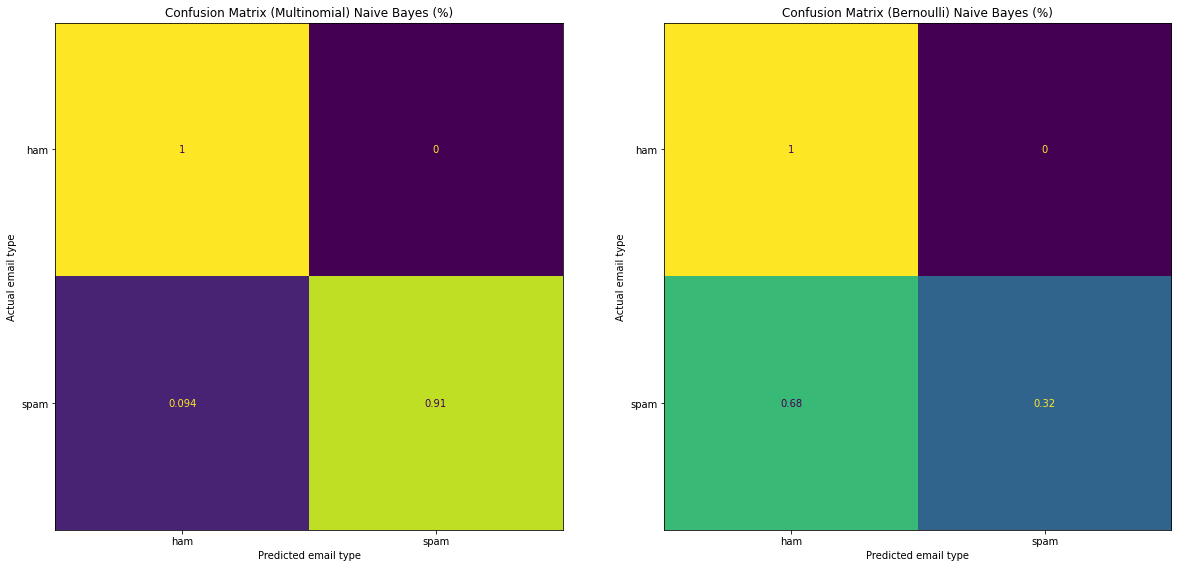

In [7]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

def compare_naive_bayes(X_train, X_test, y_train, y_test, cv=None):
  cv = cv or CountVectorizer()
  X_train_vector = cv.fit_transform(X_train)
  X_test_vector = cv.transform(X_test)
  models = [MultinomialNB().fit(X_train_vector, y_train), 
            BernoulliNB().fit(X_train_vector, y_train)]

  _, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
  for i, model in enumerate(models):
    y_pred = model.predict(X_test_vector)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print(f"True positive ({'Multinomial' if i==0 else 'Bernoulli'}): {tp/(fn+tp)}")
    print(f"True negative ({'Multinomial' if i==0 else 'Bernoulli'}): {tn/(fp+tn)}")
    plot_confusion_matrix(model, X_test_vector, y_test, ax=axs[i], colorbar=False, normalize='true')
    axs[i].set_title(f"Confusion Matrix ({'Multinomial' if i==0 else 'Bernoulli'}) Naive Bayes (%)")
    axs[i].set_xlabel("Predicted email type")
    axs[i].set_ylabel("Actual email type")

compare_naive_bayes(X_train, X_test, y_train, y_test)


### 3.Run on hard ham:
Run the two models from Question 2 on spam versus hard-ham and compare to easy-ham results.

True positive (Multinomial): 0.8333333333333334
True negative (Multinomial): 1.0
True positive (Bernoulli): 0.4895833333333333
True negative (Bernoulli): 0.9980582524271845


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


True positive (Multinomial): 1.0
True negative (Multinomial): 0.7924528301886793
True positive (Bernoulli): 1.0
True negative (Bernoulli): 0.6981132075471698


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


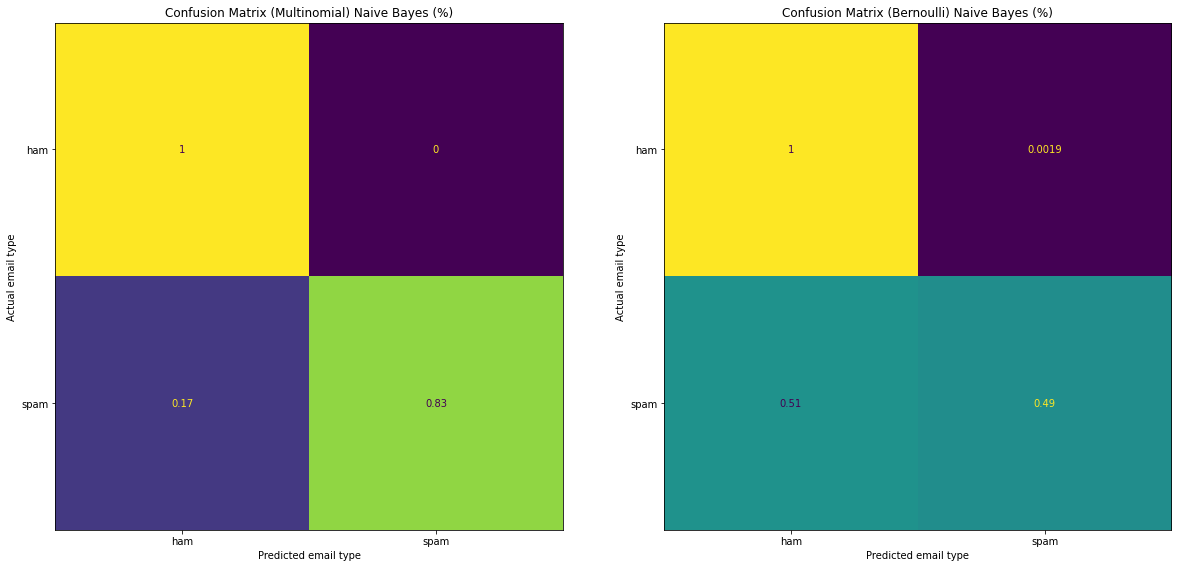

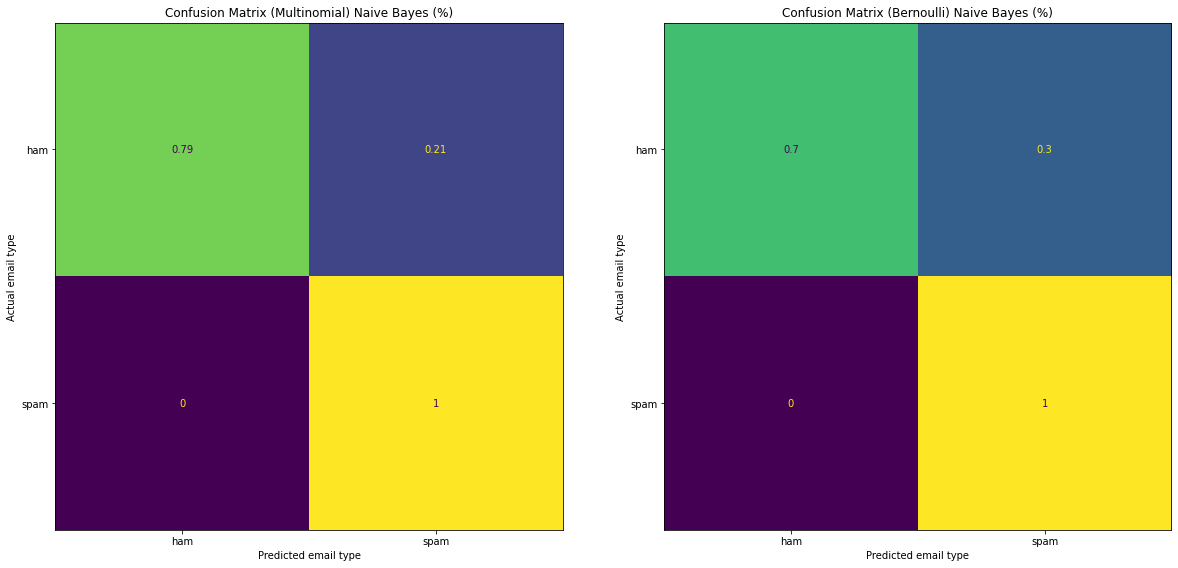

In [5]:
#
#
#
#
#
def spam_vs_ham(ham_type, cv=None, fit_prior = None):
  if ham_type == "easy":
    ham_df = df_easy_ham
  else:
    ham_df = df_hard_ham
  spam_vs_ham = pd.concat([df_spam, ham_df])
  X = spam_vs_ham['content']
  y = spam_vs_ham['class']
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
  compare_naive_bayes(X_train, X_test, y_train, y_test)

spam_vs_ham("easy")
spam_vs_ham("hard")


### 4.	OPTIONAL - NOT MARKED: 
To avoid classification based on common and uninformative words it is common to filter these out. 

**a.** Think about why this may be useful. Show a few examples of too common and too uncommon words. 

**b.** Use the parameters in scikit-learn’s `CountVectorizer` to filter out these words. Update the program from point 2 and run it on easy ham vs spam and hard ham vs spam and report your results.

In [ ]:
#Write your code here

### 5. OPTIONAL - NOT MARKED: Eeking out further performance
Filter out the headers and footers of the emails before you run on them. The format may vary somewhat between emails, which can make this a bit tricky, so perfect filtering is not required. Run your program again and answer the following questions: 
- Does the result improve from 3 and 4? 
- What do you expect would happen if your training set were mostly spam messages while your test set were mostly ham messages or vice versa? 
- Look at the `fit_prior` parameter. What does this parameter mean? Discuss in what settings it can be helpful (you can also test your hypothesis). 

In [ ]:
#Write your code here